# Inference et Visualisation des Confiances

Ce notebook charge les modèles entraînés (sauvegardés dans `models/`), effectue des prédictions sur un ensemble d'images et visualise:

- La prédiction top-1
- Les probabilités (confiances) pour chaque classe
- Un graphique barre des top-k classes
- Option pour activer MC Dropout (si le modèle en contient) pour estimer l'incertitude (variance intra-prédictions)

Ajustez `IMAGE_SOURCE_MODE` pour utiliser soit:
- `folder`: un dossier d'images (ex: un sous-ensemble du dataset)
- `list`: une liste manuelle de chemins

Pour l'inference voici le lien des données utilisées : 
- https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification?resource=download


In [1]:
# Imports
import os
import json
from pathlib import Path
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from torchvision.datasets import ImageFolder


# Device
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device utilisé:', DEVICE)

Device utilisé: cuda:0


In [2]:
# Discovery des modèles: récupérer uniquement le plus récent pour chaque stratégie d'acquisition
from pathlib import Path
import re

MODELS_ROOT = Path('../Training/models')  # adapter si nécessaire
assert MODELS_ROOT.exists(), f"Le dossier {MODELS_ROOT} n'existe pas. Lancer un entraînement d'abord." 

pattern = re.compile(r'^learner_(?P<strategy>.+?)_full_(?P<ts>\d{8}_\d{6})$')
latest_models = {}  # strategy -> (timestamp, path)
for p in MODELS_ROOT.iterdir():
    if not p.is_dir():
        continue
    m = pattern.match(p.name)
    if not m:
        continue
    strat = m.group('strategy')
    ts = m.group('ts')
    prev = latest_models.get(strat)
    if prev is None or ts > prev[0]:  # lexicographic compare ok with YYYYMMDD_HHMMSS
        latest_models[strat] = (ts, p)

if not latest_models:
    raise RuntimeError("Aucun modèle correspondant au pattern 'learner_<strategy>_full_<timestamp>' trouvé.")

print("Stratégies détectées et dernier modèle disponible:")
for strat, (ts, path) in latest_models.items():
    print(f"- {strat}: {path.name}")

# Choisir une stratégie à utiliser (modifier la variable ci-dessous)
STRATEGY_TO_USE = 'max_entropy'  # Ex: 'bald', 'mean_std_acquisition', 'var_ratios'
if STRATEGY_TO_USE not in latest_models:
    raise ValueError(f"STRATEGY_TO_USE='{STRATEGY_TO_USE}' non trouvé parmi: {list(latest_models.keys())}")

SELECTED_MODEL_PATH = latest_models[STRATEGY_TO_USE][1]
print('Modèle sélectionné pour la stratégie', STRATEGY_TO_USE, ':', SELECTED_MODEL_PATH)

# Option: pour charger tous les modèles récents, décommenter ci-dessous
# ALL_SELECTED_MODEL_PATHS = {k: v[1] for k, v in latest_models.items()}

Stratégies détectées et dernier modèle disponible:
- bald: learner_bald_full_20250725_000355
- max_entropy: learner_max_entropy_full_20250724_164900
- mean_std_acquisition: learner_mean_std_acquisition_full_20250725_072127
- var_ratios: learner_var_ratios_full_20250725_143839
Modèle sélectionné pour la stratégie max_entropy : ..\Training\models\learner_max_entropy_full_20250724_164900


In [3]:
# Fonction pour reconstruire le modèle (suppose VGG16 même head modifié)
from torchvision import models
import torch.nn as nn

def load_trained_model(model_dir: Path, device=DEVICE):
    metadata_path = model_dir / 'metadata.json'
    weights_path = model_dir / 'pytorch_model.pth'
    assert metadata_path.exists() and weights_path.exists(), 'Fichiers manquants dans le dossier modèle.'
    with open(metadata_path, 'r') as f:
        meta = json.load(f)
    state = torch.load(weights_path, map_location=device)
    model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
    n_classes = state['model_state_dict']['classifier.6.weight'].shape[0]
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, n_classes)
    model.load_state_dict(state['model_state_dict'])
    model.to(device)
    model.eval()
    return model, meta, n_classes

model, metadata, N_CLASSES = load_trained_model(SELECTED_MODEL_PATH)
print('Stratégie:', STRATEGY_TO_USE)
print('Classes détectées (n):', N_CLASSES)
print('Clés metrics:', list(metadata['metrics'].keys()))

Stratégie: max_entropy
Classes détectées (n): 9
Clés metrics: ['final_accuracy', 'final_f1', 'final_precision', 'final_recall', 'auc_curve', 'auc_scores', 'training_history', 'val_accuracies_curve']


# Chargement d'images aleatoire

In [4]:
# Préparation des transformations d'inférence (doivent matcher l'entraînement sans augmentation aléatoire)
inference_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dossiers
TRAIN_DATA_FOLDER = Path('../RealWaste')            # dossier utilisé à l'entraînement (référence pour l'ordre des classes)
EXTERNAL_DATA_FOLDER = Path('../Garbage')           # nouvelles données pour test généralisation

# Paramètres d'échantillonnage pour la visualisation
SAMPLE_PER_CLASS = 5   # nombre d'images aléatoires par classe externe (après mapping) à prélever
RANDOM_SEED = 42       # pour reproductibilité (None pour aléatoire pur)
# Exclusions explicites côté dataset externe
EXCLUDE_EXTERNAL_CLASSES = {c.lower() for c in ['trash', 'battery', 'shoes']}  # classes externes à ignorer

if RANDOM_SEED is not None:
    import random
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

# Charger dataset d'entraînement pour récupérer l'ordre ALPHABÉTIQUE des classes (ImageFolder)
train_ds = ImageFolder(root=str(TRAIN_DATA_FOLDER), transform=inference_tf)
train_class_to_idx = train_ds.class_to_idx              # {'Cardboard':0, ...}
idx_to_class = {v: k for k, v in train_class_to_idx.items()}  # {0:'Cardboard', ...}
print('Classes (train) -> index:', train_class_to_idx)

# Sécurité : vérifier que les nouvelles cibles existent bien dans le dataset d'entraînement
for required_cls in ['Food Organics', 'Textile Trash']:
    if required_cls not in train_class_to_idx:
        print(f"⚠️ AVERTISSEMENT: La classe d'entraînement '{required_cls}' est absente du dossier RealWaste.")

# Charger dataset externe
_tmp_ds = ImageFolder(root=str(EXTERNAL_DATA_FOLDER), transform=inference_tf)
external_classes = _tmp_ds.classes
print('Classes externes détectées:', external_classes)
print('Classes externes exclues:', EXCLUDE_EXTERNAL_CLASSES)

# Mapping manuel (case-insensitive) entre classes externes et classes d'entraînement
# Nouvelle nomenclature : biological -> Food Organics, clothes -> Textile Trash
external_to_train = {
    'cardboard': 'Cardboard',
    'glass': 'Glass',
    'metal': 'Metal',
    'paper': 'Paper',
    'plastic': 'Plastic',
    'biological': 'Food Organics',      # nouveau mapping
    'clothes': 'Textile Trash',         # nouveau mapping
    # 'trash' (et variantes) exclu explicitement via EXCLUDE_EXTERNAL_CLASSES
}
print('Mapping externe -> train:', external_to_train)

missing_classes = []  # externes sans correspondance et non exclues

# Fonction de mapping label externe -> index entraînement (avec fallback heuristique)
def map_external_label(ext_label_idx: int):
    raw_name = _tmp_ds.classes[ext_label_idx]
    key = raw_name.lower().replace('-', ' ').replace('_', ' ').strip()
    if key in EXCLUDE_EXTERNAL_CLASSES:
        return None  # exclusion explicite
    mapped_train_name = external_to_train.get(key)
    if mapped_train_name is None:
        # tentative heuristique Title Case si correspond exactement à une classe du train
        tentative = raw_name.title()
        if tentative in train_class_to_idx:
            mapped_train_name = tentative
    if mapped_train_name is None:
        if raw_name.lower() not in EXCLUDE_EXTERNAL_CLASSES and raw_name not in missing_classes:
            missing_classes.append(raw_name)
        return None
    return train_class_to_idx[mapped_train_name]

# Sélection aléatoire d'images par classe externe mappée (en respectant les exclusions)
selected_images = []  # liste de tuples (path, train_label)
by_class_ext = {}
for path, ext_label in _tmp_ds.samples:
    by_class_ext.setdefault(ext_label, []).append(path)

per_class_counts = {}
for ext_label, paths in by_class_ext.items():
    mapped = map_external_label(ext_label)
    if mapped is None:
        continue  # ignorer classes inconnues ou exclues
    # échantillonnage aléatoire (sans replacement)
    if len(paths) <= SAMPLE_PER_CLASS:
        chosen = paths  # tout prendre si moins que la cible
    else:
        import random
        chosen = random.sample(paths, SAMPLE_PER_CLASS)
    for p in chosen:
        selected_images.append((p, mapped))
    per_class_counts[idx_to_class[mapped]] = per_class_counts.get(idx_to_class[mapped], 0) + len(chosen)

print(f"Images sélectionnées (après mapping, exclusion & échantillonnage aléatoire): {len(selected_images)}")
print('Répartition (train class -> n images):', per_class_counts)
if missing_classes:
    print('Classes externes sans mapping (non exclues) et ignorées:', missing_classes)
else:
    print('Tous les labels externes utilisables ont été mappés avec succès.')

Classes (train) -> index: {'Cardboard': 0, 'Food Organics': 1, 'Glass': 2, 'Metal': 3, 'Miscellaneous Trash': 4, 'Paper': 5, 'Plastic': 6, 'Textile Trash': 7, 'Vegetation': 8}
Classes externes détectées: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']
Classes externes exclues: {'trash', 'shoes', 'battery'}
Mapping externe -> train: {'cardboard': 'Cardboard', 'glass': 'Glass', 'metal': 'Metal', 'paper': 'Paper', 'plastic': 'Plastic', 'biological': 'Food Organics', 'clothes': 'Textile Trash'}
Images sélectionnées (après mapping, exclusion & échantillonnage aléatoire): 35
Répartition (train class -> n images): {'Food Organics': 5, 'Cardboard': 5, 'Textile Trash': 5, 'Glass': 5, 'Metal': 5, 'Paper': 5, 'Plastic': 5}
Tous les labels externes utilisables ont été mappés avec succès.


# Fonction de prediction d'images

In [5]:
def predict_image(image_path: str, model, device=DEVICE, mc_dropout=False, mc_iterations=15):
    """
    Effectue une prédiction sur une image.
    
    Si mc_dropout est True, retourne la moyenne, l'écart-type, et les prédictions brutes
    des itérations MC Dropout.
    """
    img = Image.open(image_path).convert('RGB')
    tensor = inference_tf(img).unsqueeze(0).to(device)

    def enable_dropout(m):
        if isinstance(m, torch.nn.Dropout):
            m.train()

    if mc_dropout:
        model.apply(enable_dropout)
        all_preds = []
        with torch.no_grad():
            for _ in range(mc_iterations):
                out = model(tensor)
                probs = F.softmax(out, dim=1).cpu().numpy()[0]
                all_preds.append(probs)
        
        all_preds = np.stack(all_preds)  # Shape: (mc_iterations, n_classes)
        mean_probs = all_preds.mean(axis=0)
        std_probs = all_preds.std(axis=0)
        pred_idx = int(mean_probs.argmax())
        pred_class_name = idx_to_class[pred_idx]
        
        # 🔧 CORRECTION CRITIQUE : Remettre le modèle en mode eval après MC Dropout
        model.eval()
        
        return mean_probs, std_probs, img, pred_idx, pred_class_name, all_preds
    else:
        model.eval()
        with torch.no_grad():
            out = model(tensor)
            probs = F.softmax(out, dim=1).cpu().numpy()[0]
        pred_idx = int(probs.argmax())
        pred_class_name = idx_to_class[pred_idx]
        return probs, None, img, pred_idx, pred_class_name, None

## Test predictions

In [6]:
image_path = EXTERNAL_DATA_FOLDER / "paper/paper_1.jpg"
bald, _,_ = load_trained_model(latest_models.get("bald")[1])

In [7]:
predict_image(image_path, bald, mc_dropout=True, mc_iterations=15)

(array([6.6226673e-01, 3.3275771e-11, 9.8801161e-07, 1.3941116e-05,
        3.2993782e-01, 3.9023480e-03, 6.7647755e-07, 3.8775322e-03,
        4.1107076e-10], dtype=float32),
 array([3.9579293e-01, 1.0339240e-10, 3.6953320e-06, 3.9843919e-05,
        3.9185664e-01, 8.5060466e-03, 2.0762250e-06, 9.7192712e-03,
        1.1912996e-09], dtype=float32),
 <PIL.Image.Image image mode=RGB size=512x384>,
 0,
 'Cardboard',
 array([[4.83767949e-02, 3.26961461e-12, 1.24205446e-09, 7.79937182e-09,
         9.46514845e-01, 5.08471671e-03, 1.74830134e-07, 2.33492356e-05,
         4.71416506e-09],
        [2.35005409e-01, 7.12997647e-11, 1.48146773e-05, 2.80898421e-05,
         6.94550455e-01, 3.15923095e-02, 8.53556571e-07, 3.88080962e-02,
         8.57575747e-11],
        [9.92988884e-01, 3.75279191e-16, 1.17968363e-17, 2.13310686e-05,
         3.78987403e-04, 2.16995846e-04, 9.00460151e-10, 6.39379723e-03,
         9.83007079e-12],
        [9.99986887e-01, 1.65146461e-13, 2.56956713e-11, 1.0661494

# Fonction de representation graphique 

In [8]:
def plot_mc_prediction(result, strategy_name, color, img_idx):
    """
    Visualisation avec l'image et un bar chart des probabilités moyennes par classe.
    """
    fig, (ax_img, ax_bar) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 2]})
    
    # Affichage de l'image
    true_class = result['true_class']
    pred_class = result['pred_class']
    is_correct = true_class == pred_class
    
    ax_img.imshow(result['img'])
    ax_img.set_title(f"Image {img_idx}\nVraie classe: {true_class}", fontsize=12)
    ax_img.axis('off')
    
    # Préparation des données pour le bar chart
    class_names = list(idx_to_class.values())
    mean_probs = result['mean_probs']
    
    # Créer le bar chart
    bars = ax_bar.bar(class_names, mean_probs, color='lightblue', alpha=0.7, edgecolor='black')
    
    # Mettre en évidence la classe prédite
    pred_idx = result['pred_idx']
    bars[pred_idx].set_color(color)
    bars[pred_idx].set_alpha(0.9)
    
    # Calculer la hauteur maximale pour l'espacement
    max_prob = max(mean_probs)
    
    # Personnalisation du graphique
    ax_bar.set_title(f'Prédiction: {pred_class}', fontweight='bold', 
                     color='green' if is_correct else 'red', fontsize=14)
    ax_bar.set_ylabel('Probabilité Moyenne', fontsize=12)
    ax_bar.set_xlabel('Classes', fontsize=12)
    ax_bar.tick_params(axis='x', rotation=45)
    
    # Ajuster la limite Y
    ax_bar.set_ylim(0, max_prob * 1.2)  # Augmenter de 20% pour laisser de l'espace
    ax_bar.grid(axis='y', alpha=0.3)
    
    # Ajouter les valeurs de probabilité sur chaque barre
    for i, (bar, prob) in enumerate(zip(bars, mean_probs)):
        if prob > 0.01:  # Afficher seulement si probabilité > 1%
            text_height = bar.get_height() + max_prob * 0.02  # Espacer de 2% de la hauteur max
            ax_bar.text(bar.get_x() + bar.get_width()/2, text_height, 
                       f'{prob:.2f}', ha='center', va='bottom', fontsize=9)
    
    plt.suptitle(f"{strategy_name.upper()} - Rang {img_idx} (Entropie: {result['entropy']:.3f})", 
                 fontsize=14, fontweight='bold', color=color)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig

# Fonction d'analyse de resultat

In [9]:
from scipy.stats import entropy as _entropy
import numpy as np

# Fonction simplifiée pour analyser les prédictions avec visualisation épurée
UNCERTAINTY_MC_ITER = 15
N_IMAGES_PER_STRATEGY = 4
plt.style.use('default')

def analyze_strategy_simple(image_path: str, model, strategy_name: str, mc_iterations=UNCERTAINTY_MC_ITER):
    """Analyse simplifiée d'une image avec calcul d'entropie normalisée.

    L'entropie est divisée par son maximum (log du nombre de classes)
    pour obtenir une valeur comprise entre 0 et 1.
    """

    # Utiliser predict_image pour éviter la redondance
    mean_probs, _, img, pred_idx, pred_class_name, _ = predict_image(
        image_path, model, mc_dropout=True, mc_iterations=mc_iterations
    )
    
    # Métriques essentielles
    confidence = float(mean_probs[pred_idx])
    # Calcul de l'entropie (logarithme naturel par défaut dans scipy.stats.entropy)
    entropy_val = float(_entropy(mean_probs + 1e-12))
    # Entropie maximale possible pour le nombre de classes (base e)
    max_entropy = np.log(len(mean_probs))
    # Entropie normalisée entre 0 et 1
    normalized_entropy = entropy_val / max_entropy
    
    return {
        'strategy': strategy_name,
        'img': img,
        'pred_idx': pred_idx,
        'pred_class': pred_class_name,
        'confidence': confidence,
        'entropy': normalized_entropy,
        'mean_probs': mean_probs
    }


In [10]:
# ===================================================================
# CHARGEMENT DE TOUS LES MODÈLES POUR L'ANALYSE
# ===================================================================
# Cette cellule charge tous les modèles les plus récents pour chaque 
# stratégie dans un dictionnaire `all_models` pour une utilisation facile.

all_models = {}
for strategy, (ts, path) in latest_models.items():
    try:
        model_tmp, _, _ = load_trained_model(path)
        all_models[strategy] = model_tmp
        print(f"✓ Modèle '{strategy}' chargé avec succès.")
    except Exception as e:
        print(f"✗ Erreur de chargement pour le modèle '{strategy}': {e}")

print(f"\n🎯 {len(all_models)} modèles sont prêts pour l'analyse.")
print("📋 Stratégies disponibles:", list(all_models.keys()))

✓ Modèle 'bald' chargé avec succès.
✓ Modèle 'max_entropy' chargé avec succès.
✓ Modèle 'max_entropy' chargé avec succès.
✓ Modèle 'mean_std_acquisition' chargé avec succès.
✓ Modèle 'mean_std_acquisition' chargé avec succès.
✓ Modèle 'var_ratios' chargé avec succès.

🎯 4 modèles sont prêts pour l'analyse.
📋 Stratégies disponibles: ['bald', 'max_entropy', 'mean_std_acquisition', 'var_ratios']
✓ Modèle 'var_ratios' chargé avec succès.

🎯 4 modèles sont prêts pour l'analyse.
📋 Stratégies disponibles: ['bald', 'max_entropy', 'mean_std_acquisition', 'var_ratios']


# Bald

🎯 Analyse simplifiée - Stratégie: BALD

📊 Top 4 images avec le PLUS d'entropie:

📊 Top 4 images avec le PLUS d'entropie:


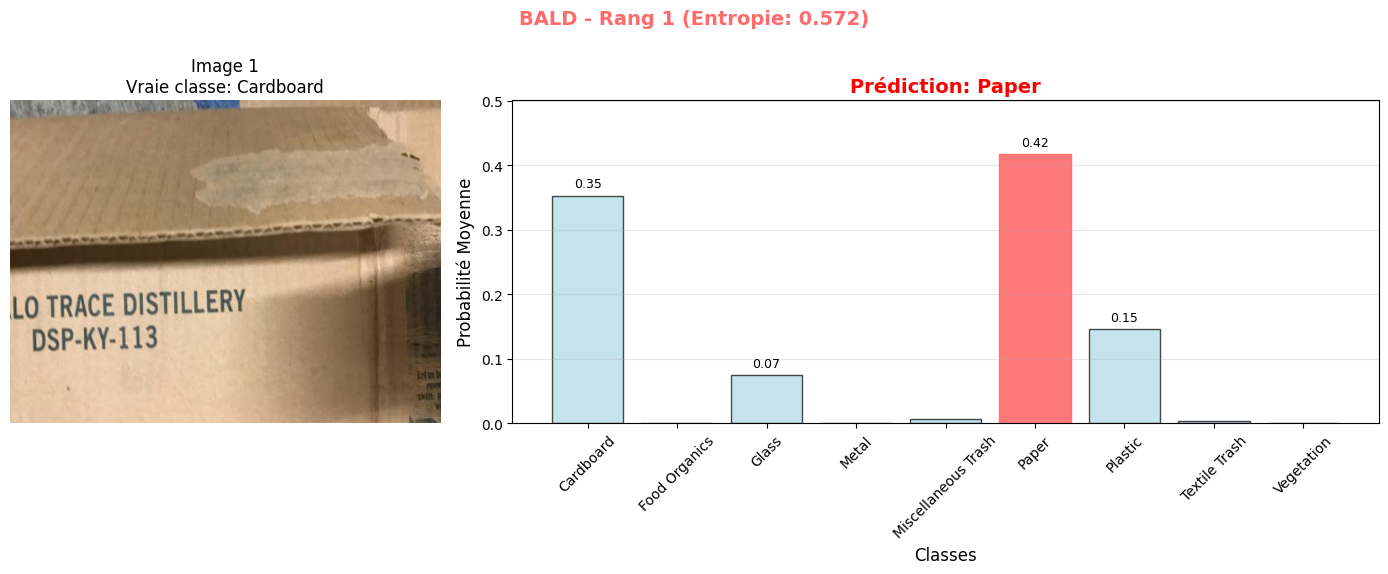

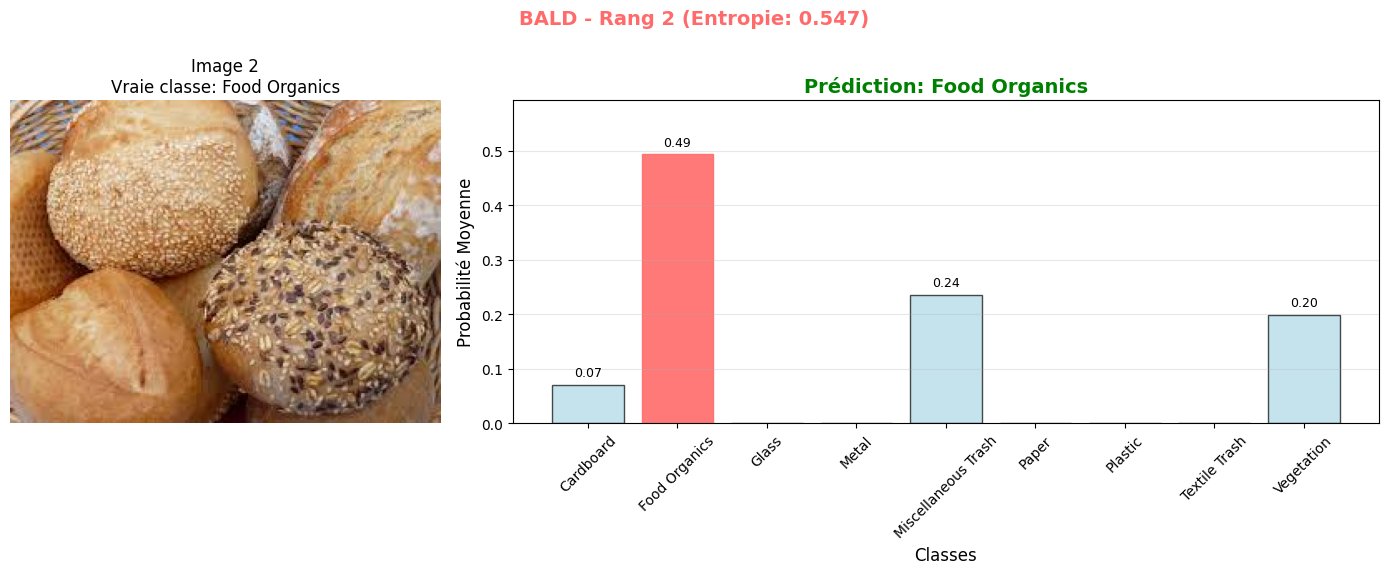

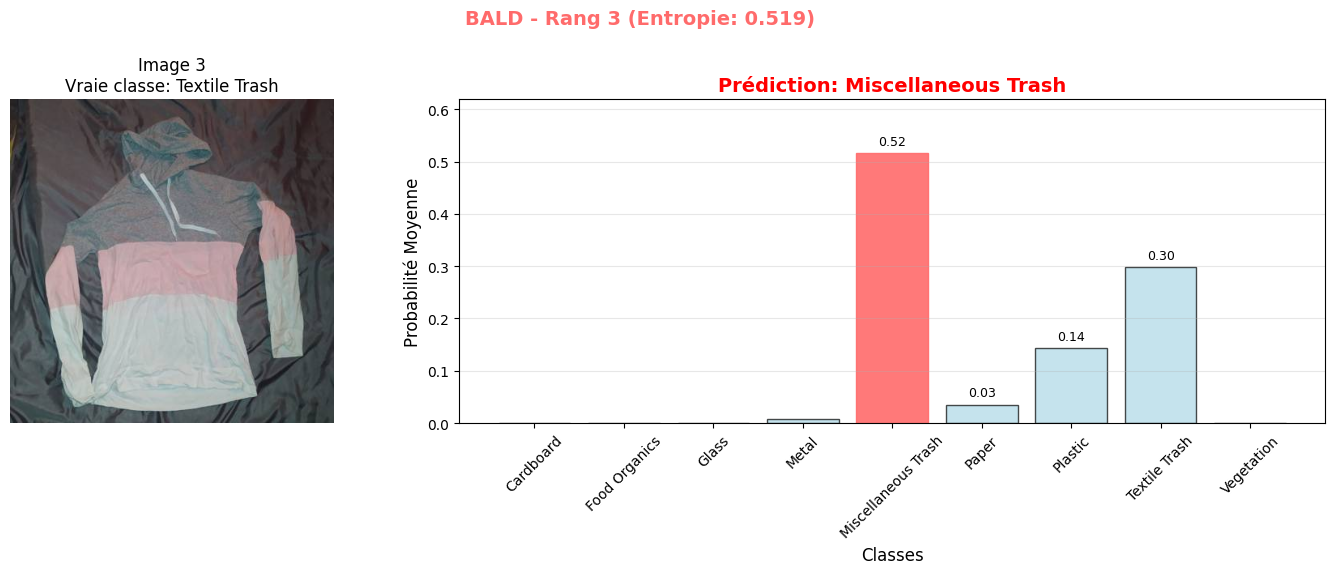

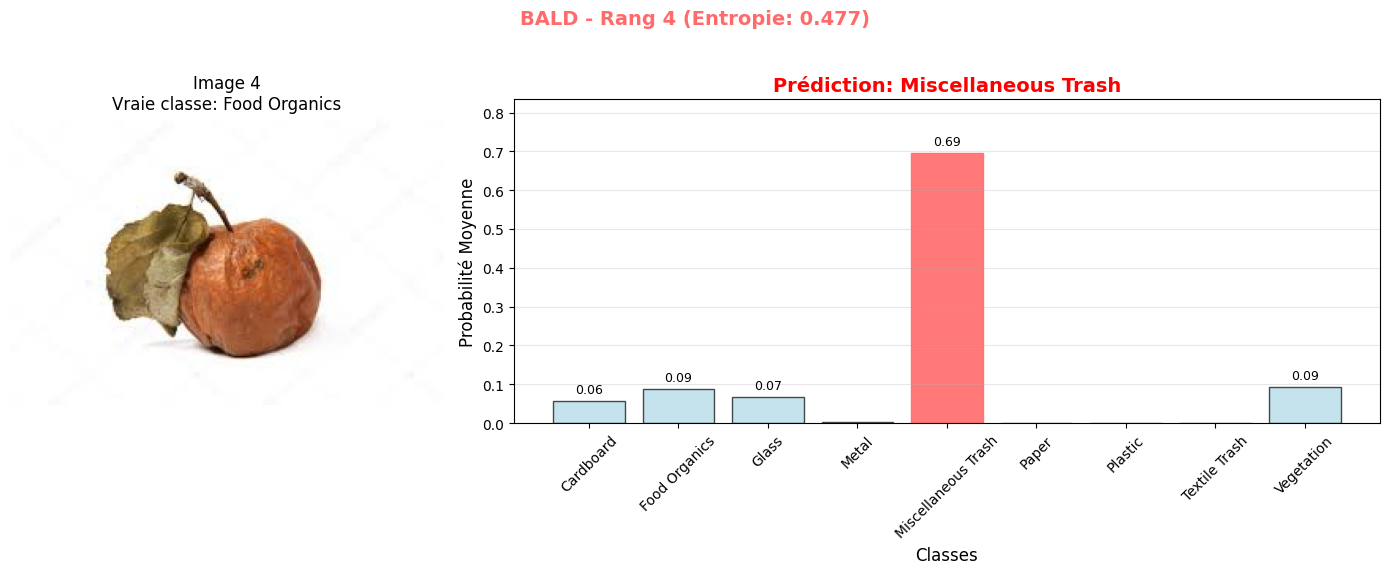


📉 Top 4 images avec le MOINS d'entropie (les plus sûres):


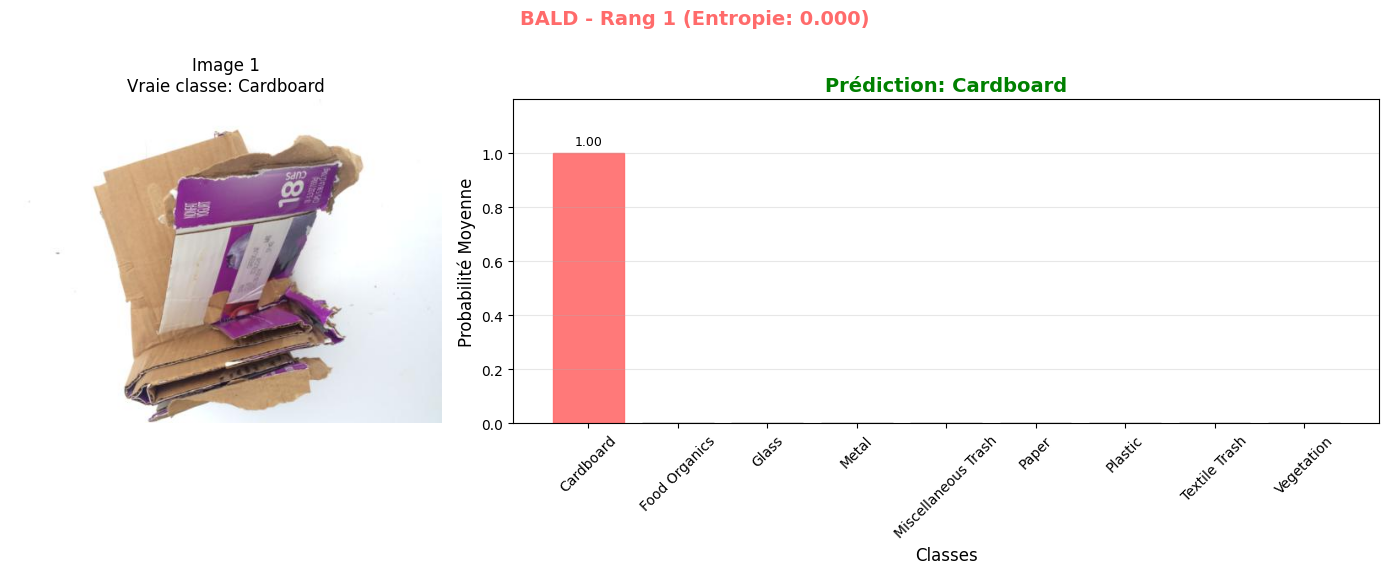

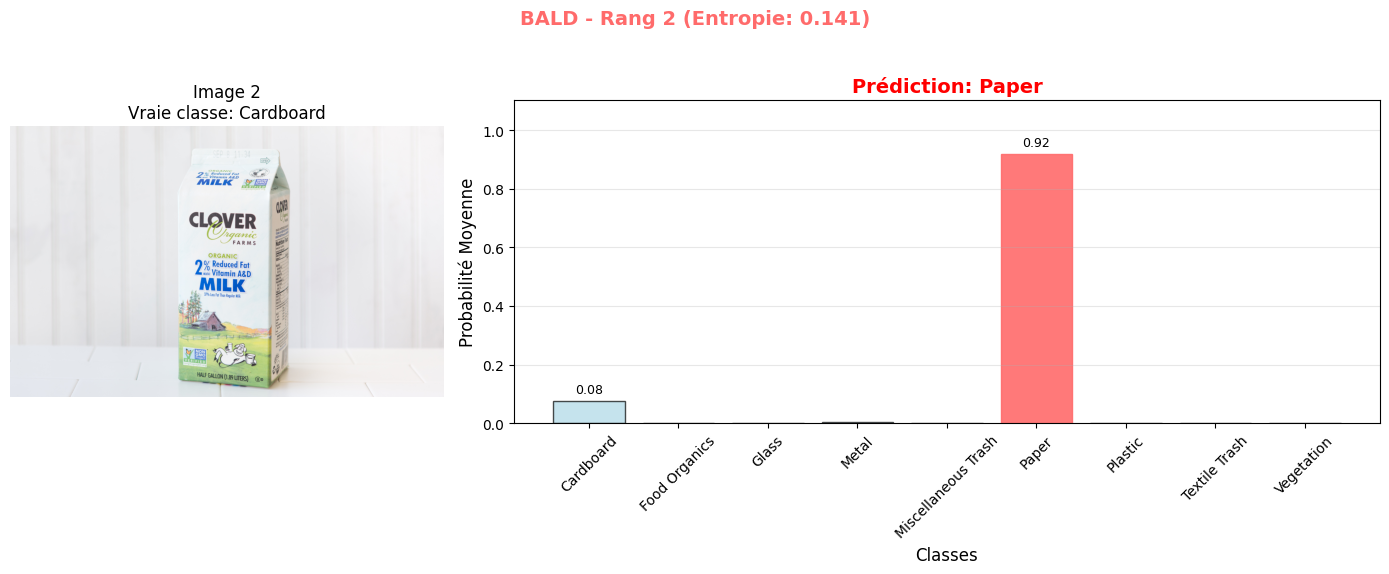

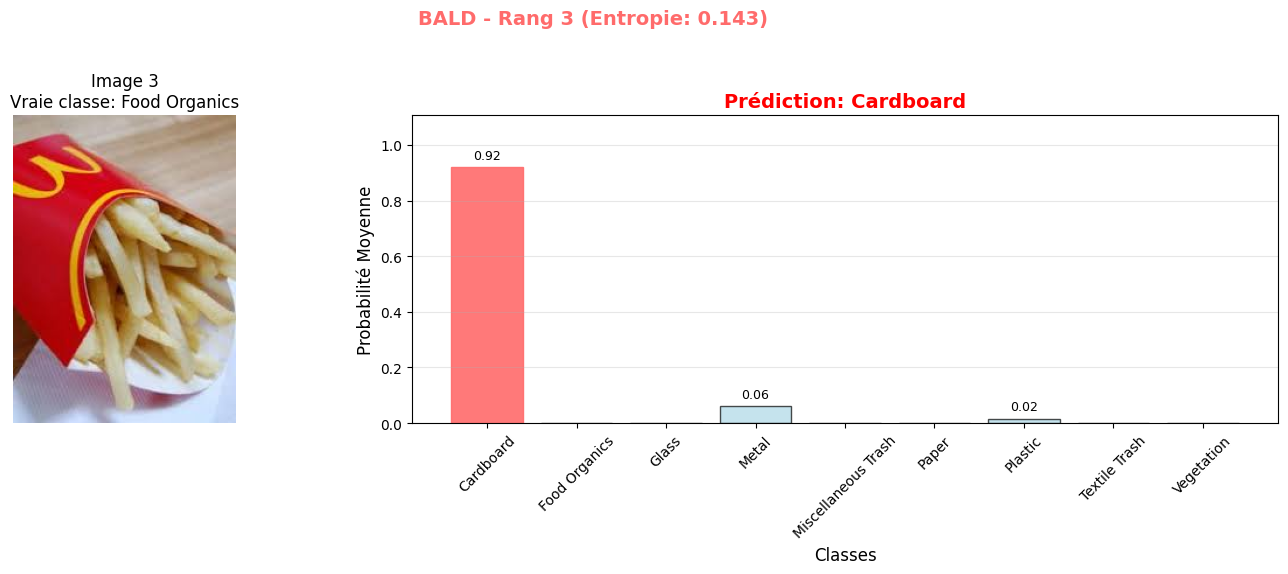

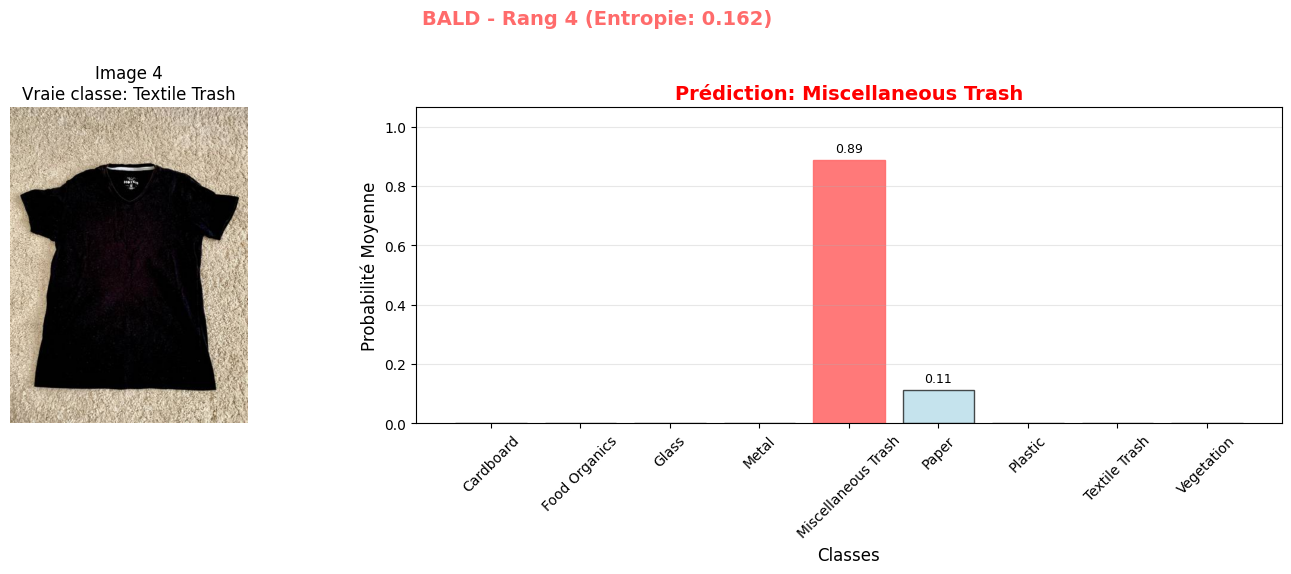


📈 Résumé BALD (12 images):
   • Précision: 4/12 (33.3%)
   • Confiance moyenne: 0.723 (±0.189)
   • Entropie moyenne: 0.322 (±0.181)
✅ Analyse BALD simplifiée terminée


In [11]:
# 🧠 Analyse BALD - Version Simplifiée
if 'bald' not in all_models:
    print("❌ Modèle BALD non disponible")
else:
    strategy_name = 'bald'
    model_bald = all_models[strategy_name]
    color = '#FF6B6B'
    
    print(f"🎯 Analyse simplifiée - Stratégie: {strategy_name.upper()}")
    
    # Analyser un ensemble d'images
    bald_results = []
    for img_path, true_lbl in selected_images[:12]:  # Analyser 12 images
        result = analyze_strategy_simple(img_path, model_bald, strategy_name)
        result['true_class'] = idx_to_class[true_lbl]
        bald_results.append(result)
    
    # --- Visualisation des images avec le PLUS d'entropie (incertitude) ---
    bald_results.sort(key=lambda x: x['entropy'], reverse=True)
    print(f"\n📊 Top {N_IMAGES_PER_STRATEGY} images avec le PLUS d'entropie:")
    for idx, result in enumerate(bald_results[:N_IMAGES_PER_STRATEGY]):
        fig = plot_mc_prediction(result, strategy_name, color, idx + 1)
        plt.show()
        
    # --- Visualisation des images avec le MOINS d'entropie (les plus sûres) ---
    bald_results.sort(key=lambda x: x['entropy'], reverse=False) # Tri ascendant
    print(f"\n📉 Top {N_IMAGES_PER_STRATEGY} images avec le MOINS d'entropie (les plus sûres):")
    for idx, result in enumerate(bald_results[:N_IMAGES_PER_STRATEGY]):
        fig = plot_mc_prediction(result, strategy_name, color, idx + 1)
        plt.show()
    
    # Résumé statistique global (sur toutes les images analysées)
    confidences = [r['confidence'] for r in bald_results]
    entropies = [r['entropy'] for r in bald_results]
    correct_preds = sum(1 for r in bald_results if r['pred_class'] == r['true_class'])
    
    print(f"\n📈 Résumé BALD ({len(bald_results)} images):")
    print(f"   • Précision: {correct_preds}/{len(bald_results)} ({100*correct_preds/len(bald_results):.1f}%)")
    print(f"   • Confiance moyenne: {np.mean(confidences):.3f} (±{np.std(confidences):.3f})")
    print(f"   • Entropie moyenne: {np.mean(entropies):.3f} (±{np.std(entropies):.3f})")
    print("✅ Analyse BALD simplifiée terminée")

# Max entropy

🎯 Analyse simplifiée - Stratégie: MAX_ENTROPY

📊 Top 4 images avec le PLUS d'entropie:

📊 Top 4 images avec le PLUS d'entropie:


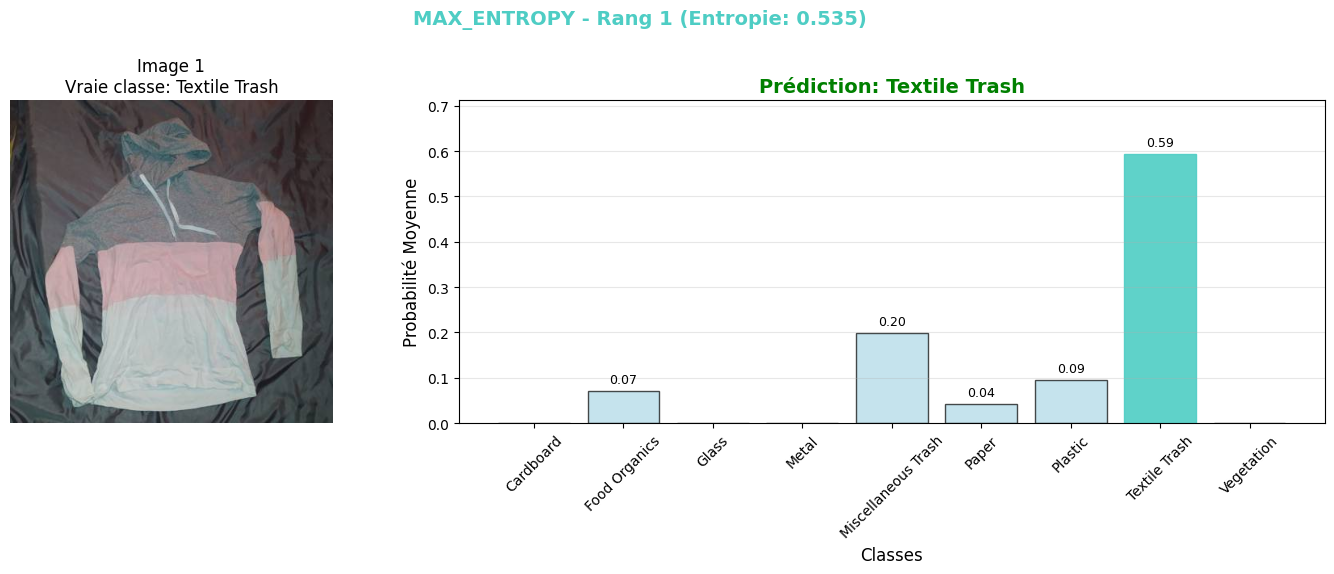

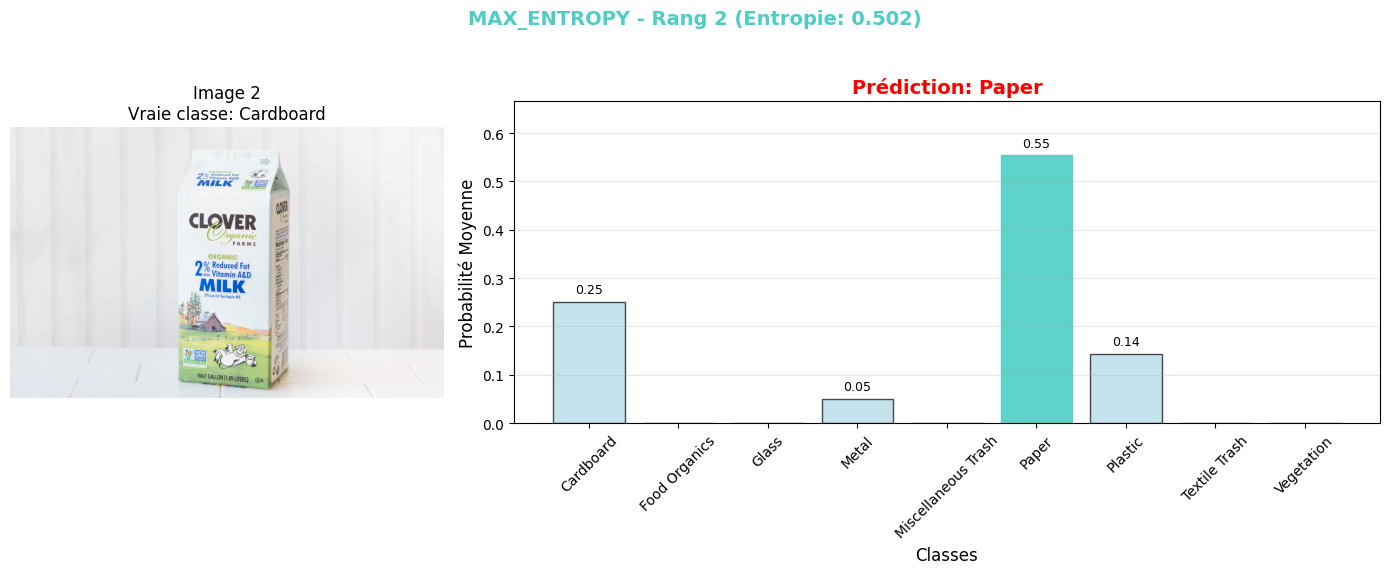

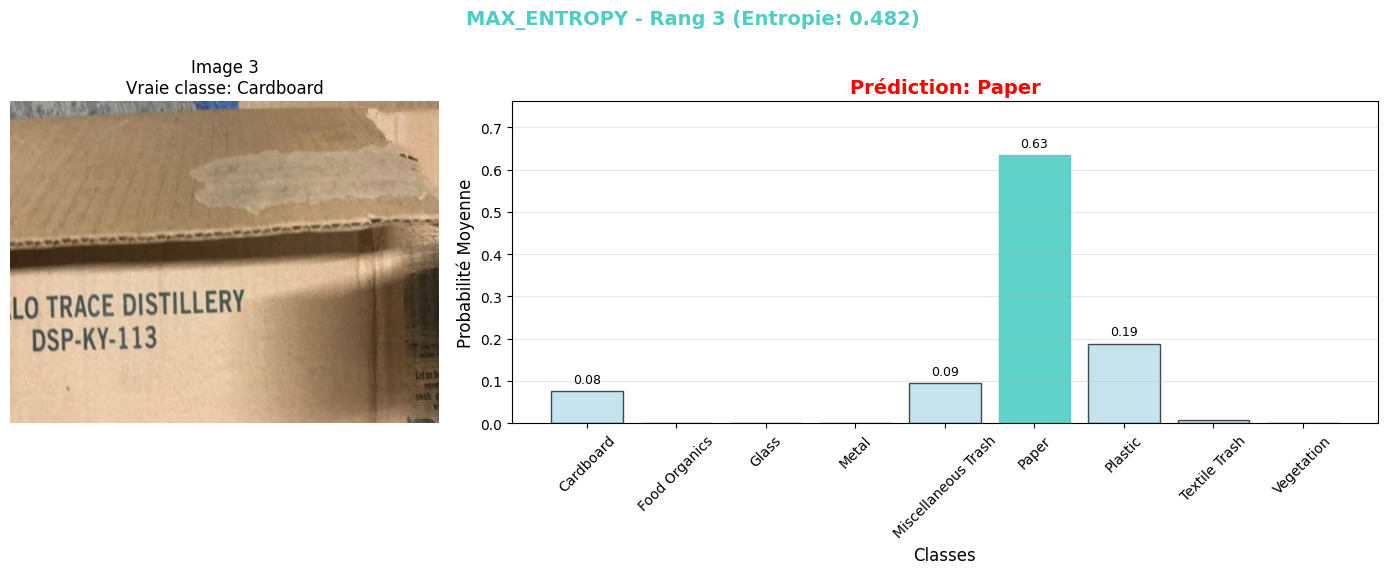


📉 Top 4 images avec le MOINS d'entropie (les plus sûres):


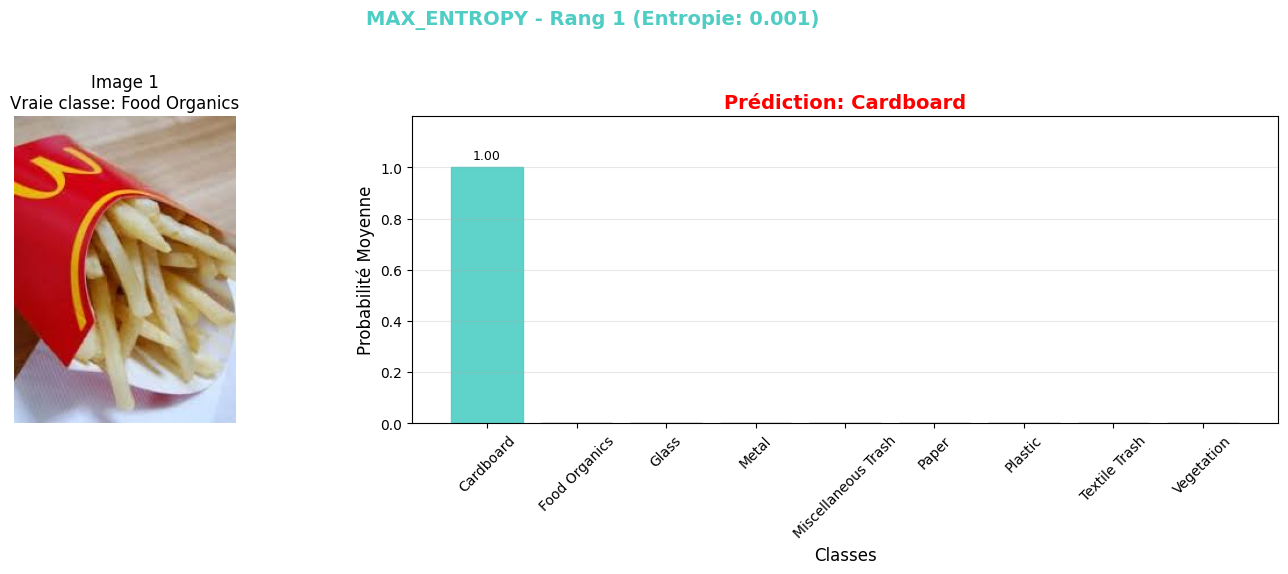

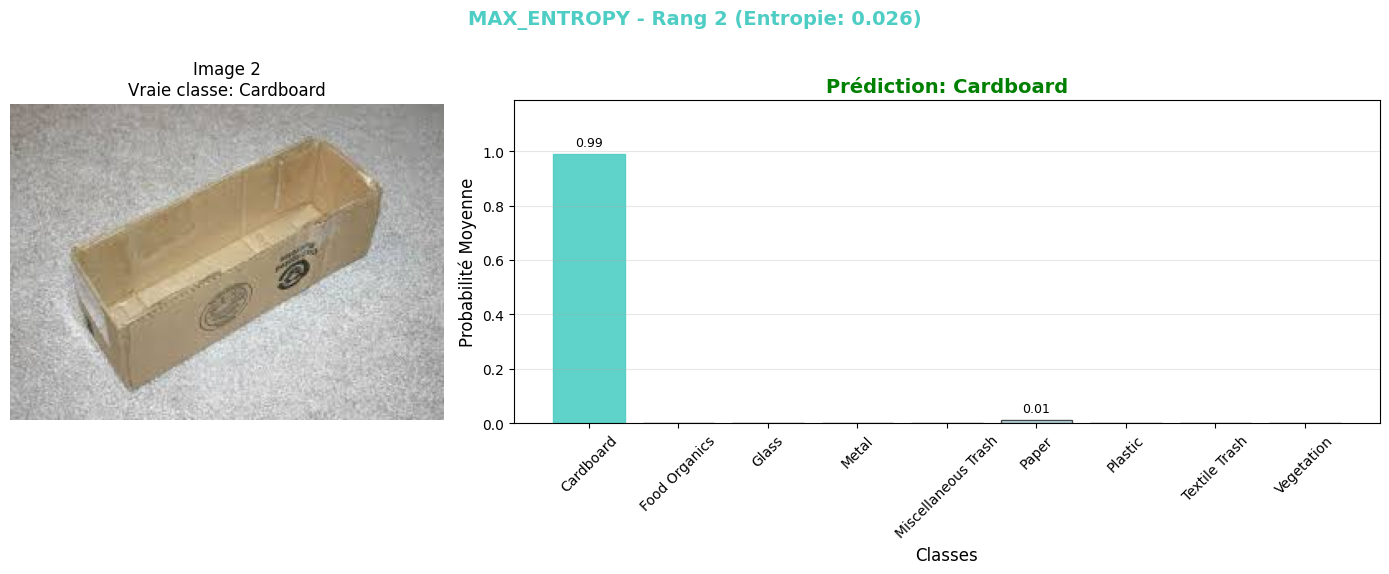

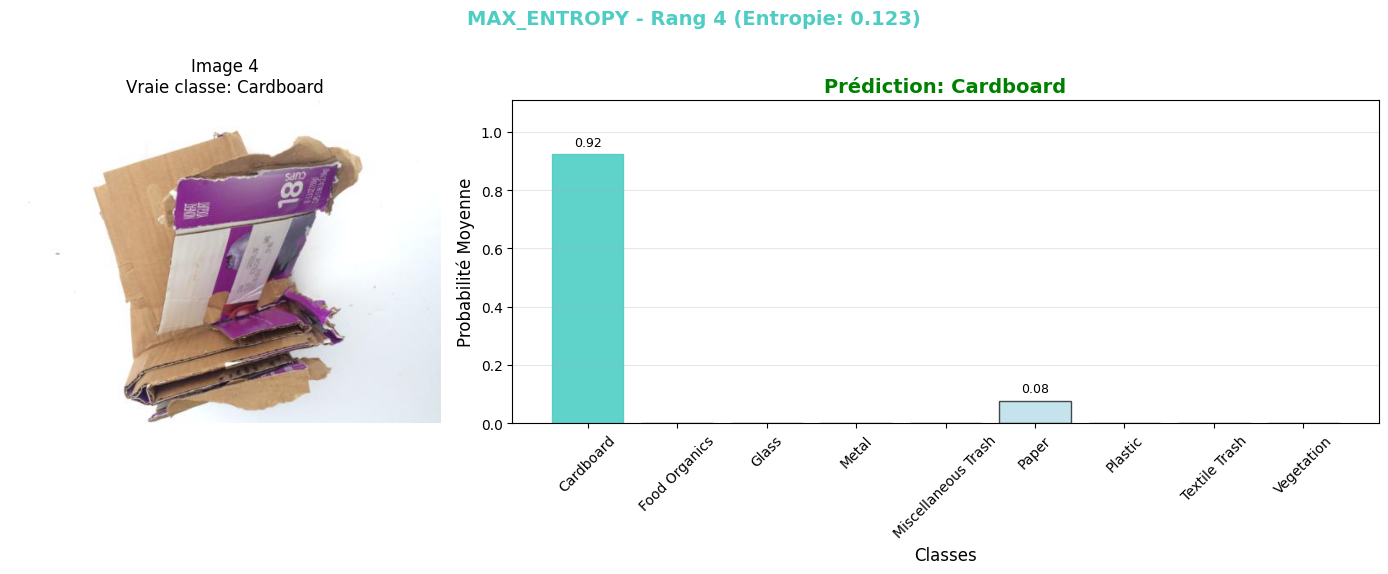


📈 Résumé MAX ENTROPY (12 images):
   • Précision: 5/12 (41.7%)
   • Confiance moyenne: 0.751 (±0.172)
   • Entropie moyenne: 0.295 (±0.183)
✅ Analyse Max Entropy simplifiée terminée


In [12]:
# 🎯 Analyse MAX ENTROPY - Version Simplifiée
if 'max_entropy' not in all_models:
    print("❌ Modèle Max Entropy non disponible")
else:
    strategy_name = 'max_entropy'
    model_entropy = all_models[strategy_name]
    color = '#4ECDC4'
    
    print(f"🎯 Analyse simplifiée - Stratégie: {strategy_name.upper()}")
    
    # Analyser un ensemble d'images
    entropy_results = []
    for img_path, true_lbl in selected_images[:12]:
        result = analyze_strategy_simple(img_path, model_entropy, strategy_name)
        result['true_class'] = idx_to_class[true_lbl]
        entropy_results.append(result)
    
    # --- Visualisation des images avec le PLUS d'entropie ---
    entropy_results.sort(key=lambda x: x['entropy'], reverse=True)
    print(f"\n📊 Top {N_IMAGES_PER_STRATEGY} images avec le PLUS d'entropie:")
    for idx, result in enumerate(entropy_results[:N_IMAGES_PER_STRATEGY]):
        fig = plot_mc_prediction(result, strategy_name, color, idx + 1)
        plt.show()
        
    # --- Visualisation des images avec le MOINS d'entropie ---
    entropy_results.sort(key=lambda x: x['entropy'], reverse=False) # Tri ascendant
    print(f"\n📉 Top {N_IMAGES_PER_STRATEGY} images avec le MOINS d'entropie (les plus sûres):")
    for idx, result in enumerate(entropy_results[:N_IMAGES_PER_STRATEGY]):
        fig = plot_mc_prediction(result, strategy_name, color, idx + 1)
        plt.show()
    
    # Résumé statistique global
    confidences = [r['confidence'] for r in entropy_results]
    entropies = [r['entropy'] for r in entropy_results]
    correct_preds = sum(1 for r in entropy_results if r['pred_class'] == r['true_class'])
    
    print(f"\n📈 Résumé MAX ENTROPY ({len(entropy_results)} images):")
    print(f"   • Précision: {correct_preds}/{len(entropy_results)} ({100*correct_preds/len(entropy_results):.1f}%)")
    print(f"   • Confiance moyenne: {np.mean(confidences):.3f} (±{np.std(confidences):.3f})")
    print(f"   • Entropie moyenne: {np.mean(entropies):.3f} (±{np.std(entropies):.3f})")
    print("✅ Analyse Max Entropy simplifiée terminée")

# Mean STD

📊 Analyse simplifiée - Stratégie: MEAN_STD_ACQUISITION

📊 Top 4 images avec le PLUS d'entropie:

📊 Top 4 images avec le PLUS d'entropie:


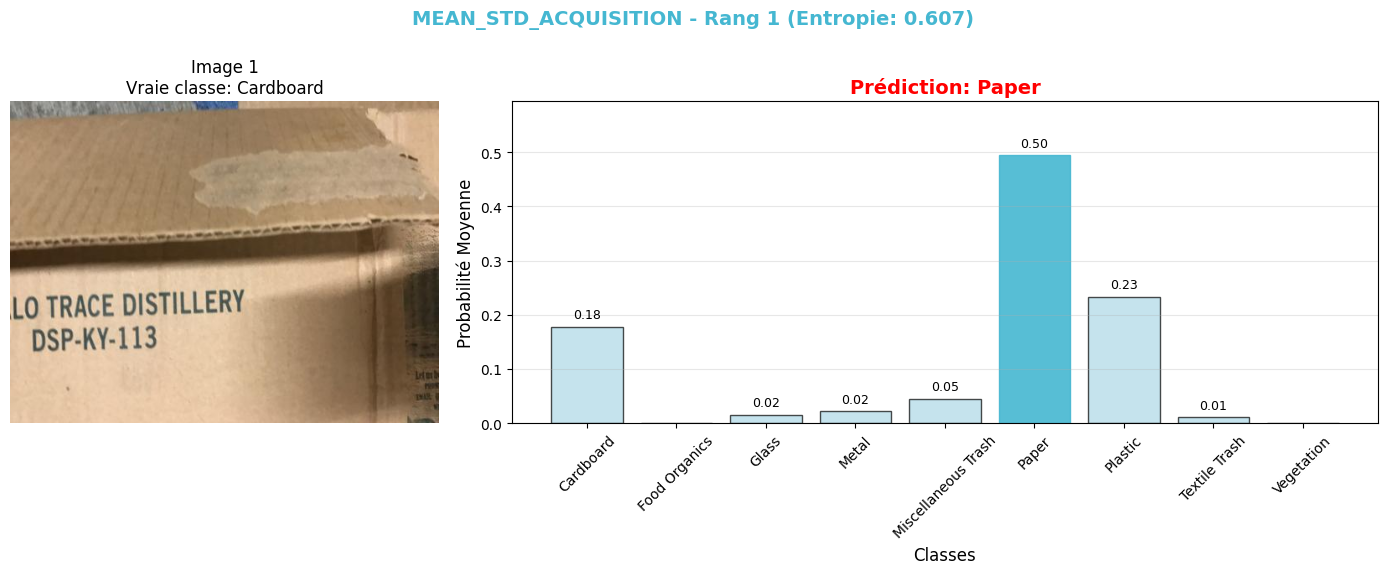

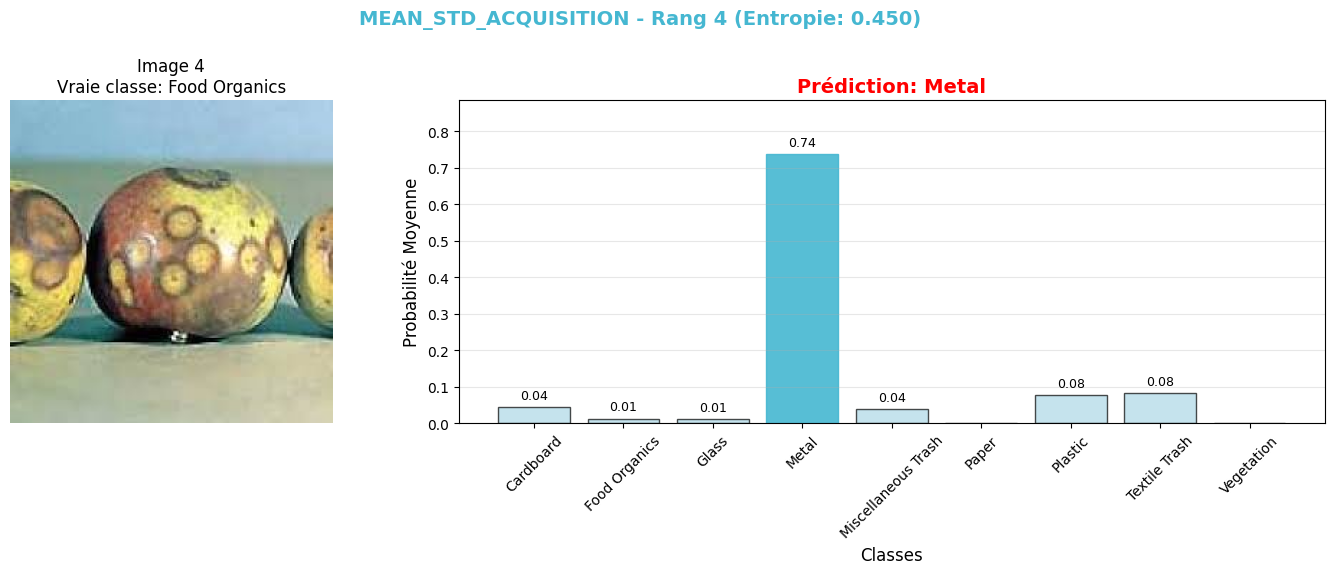


📉 Top 4 images avec le MOINS d'entropie (les plus sûres):


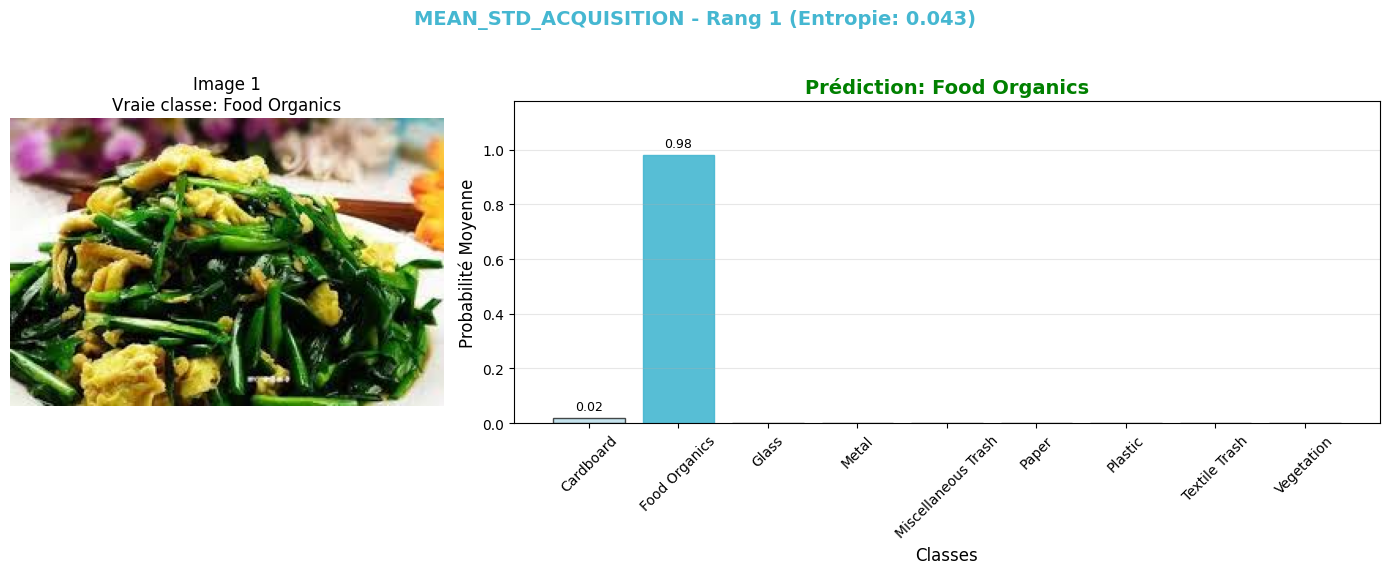

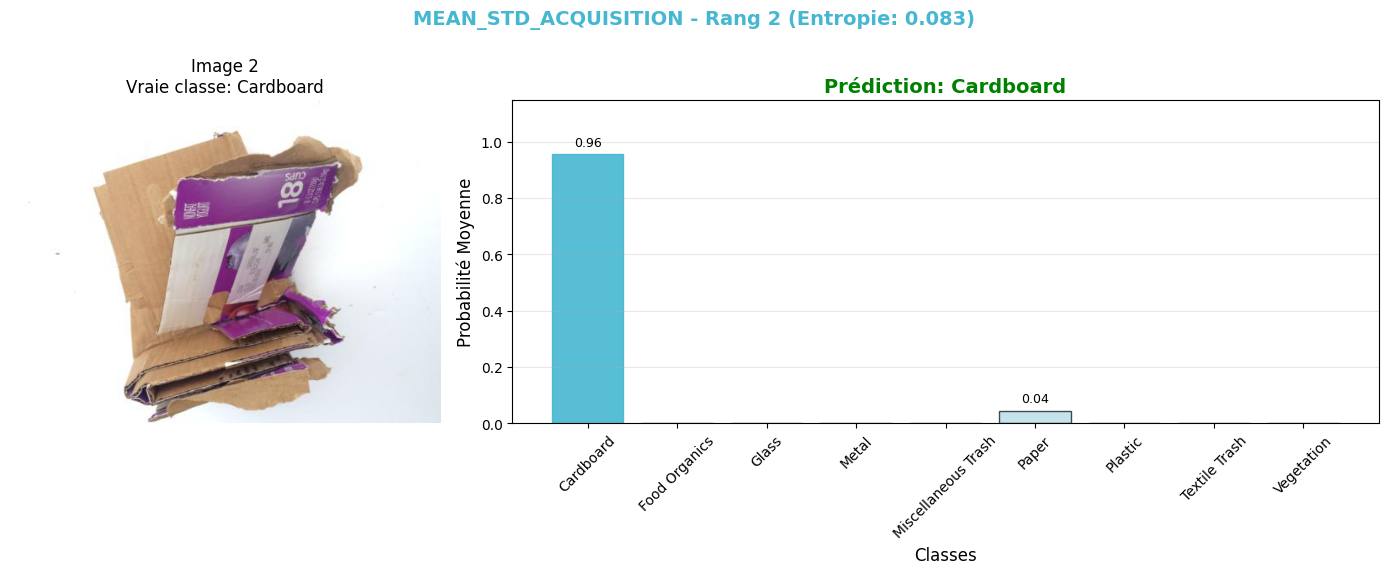

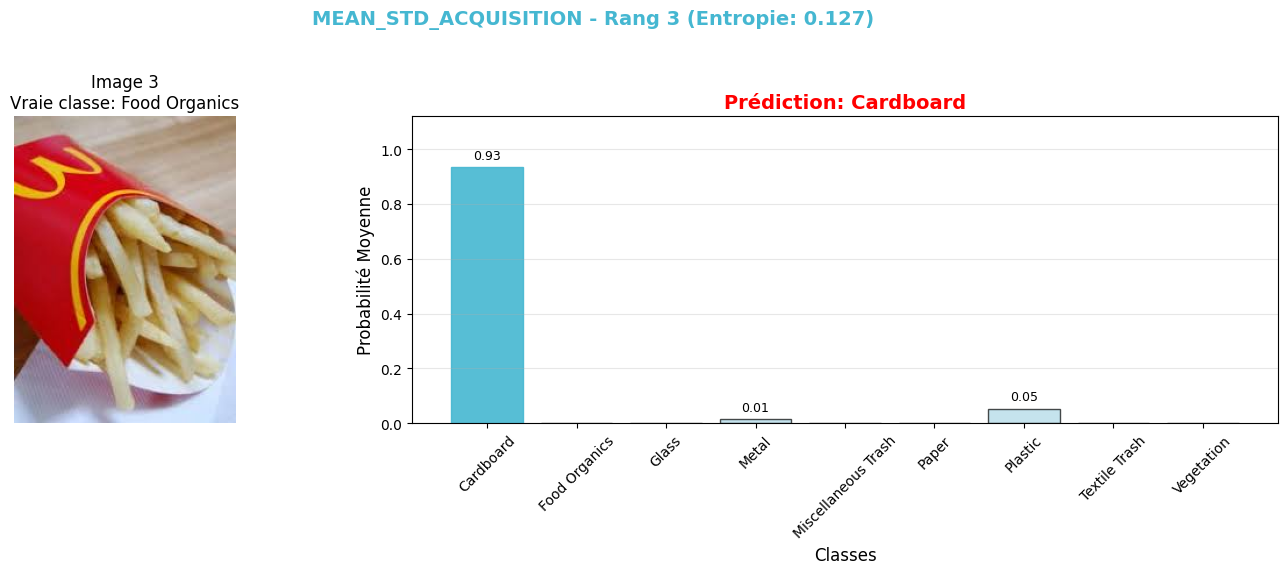


📈 Résumé MEAN STD (12 images):
   • Précision: 6/12 (50.0%)
   • Confiance moyenne: 0.714 (±0.175)
   • Entropie moyenne: 0.341 (±0.181)
✅ Analyse Mean Std simplifiée terminée


In [13]:
# 📊 Analyse MEAN STD ACQUISITION - Version Simplifiée
if 'mean_std_acquisition' not in all_models:
    print("❌ Modèle Mean Std Acquisition non disponible")
else:
    strategy_name = 'mean_std_acquisition'
    model_std = all_models[strategy_name]
    color = '#45B7D1'
    
    print(f"📊 Analyse simplifiée - Stratégie: {strategy_name.upper()}")
    
    # Analyser un ensemble d'images
    std_results = []
    for img_path, true_lbl in selected_images[:12]:
        result = analyze_strategy_simple(img_path, model_std, strategy_name)
        result['true_class'] = idx_to_class[true_lbl]
        std_results.append(result)
    
    # --- Visualisation des images avec le PLUS d'entropie ---
    std_results.sort(key=lambda x: x['entropy'], reverse=True)
    print(f"\n📊 Top {N_IMAGES_PER_STRATEGY} images avec le PLUS d'entropie:")
    for idx, result in enumerate(std_results[:N_IMAGES_PER_STRATEGY]):
        fig = plot_mc_prediction(result, strategy_name, color, idx + 1)
        plt.show()

    # --- Visualisation des images avec le MOINS d'entropie ---
    std_results.sort(key=lambda x: x['entropy'], reverse=False) # Tri ascendant
    print(f"\n📉 Top {N_IMAGES_PER_STRATEGY} images avec le MOINS d'entropie (les plus sûres):")
    for idx, result in enumerate(std_results[:N_IMAGES_PER_STRATEGY]):
        fig = plot_mc_prediction(result, strategy_name, color, idx + 1)
        plt.show()

    # Résumé statistique global
    confidences = [r['confidence'] for r in std_results]
    entropies = [r['entropy'] for r in std_results]
    correct_preds = sum(1 for r in std_results if r['pred_class'] == r['true_class'])
    
    print(f"\n📈 Résumé MEAN STD ({len(std_results)} images):")
    print(f"   • Précision: {correct_preds}/{len(std_results)} ({100*correct_preds/len(std_results):.1f}%)")
    print(f"   • Confiance moyenne: {np.mean(confidences):.3f} (±{np.std(confidences):.3f})")
    print(f"   • Entropie moyenne: {np.mean(entropies):.3f} (±{np.std(entropies):.3f})")
    print("✅ Analyse Mean Std simplifiée terminée")

# Var Ratio

🎲 Analyse simplifiée - Stratégie: VAR_RATIOS

📊 Top 4 images avec le PLUS d'entropie:

📊 Top 4 images avec le PLUS d'entropie:


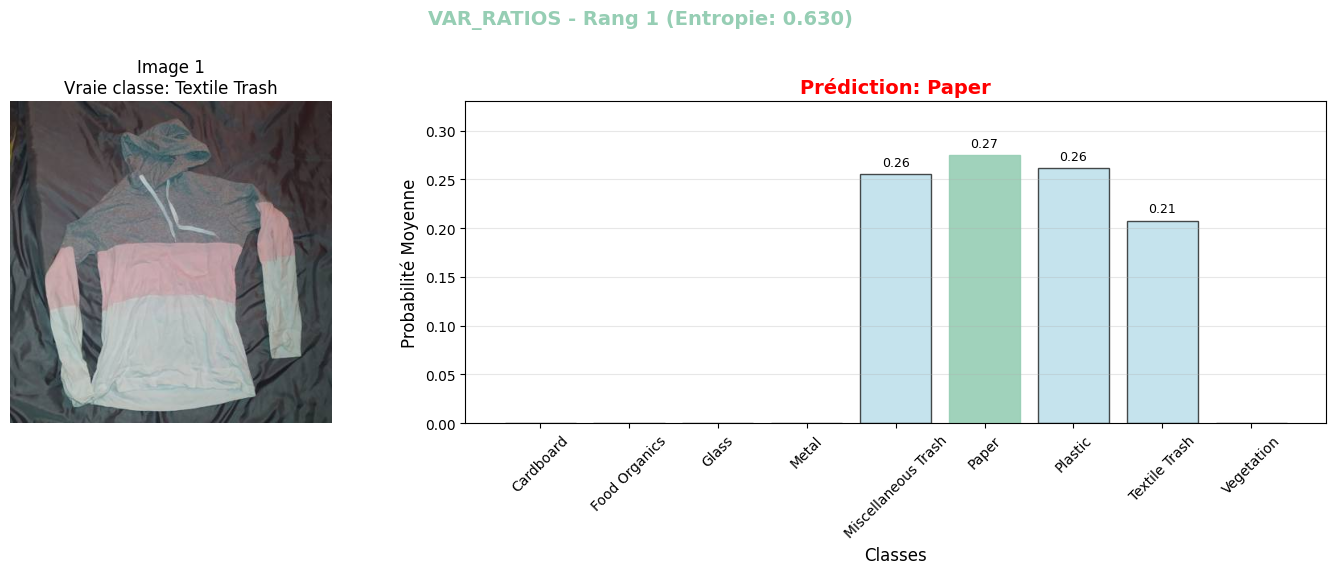

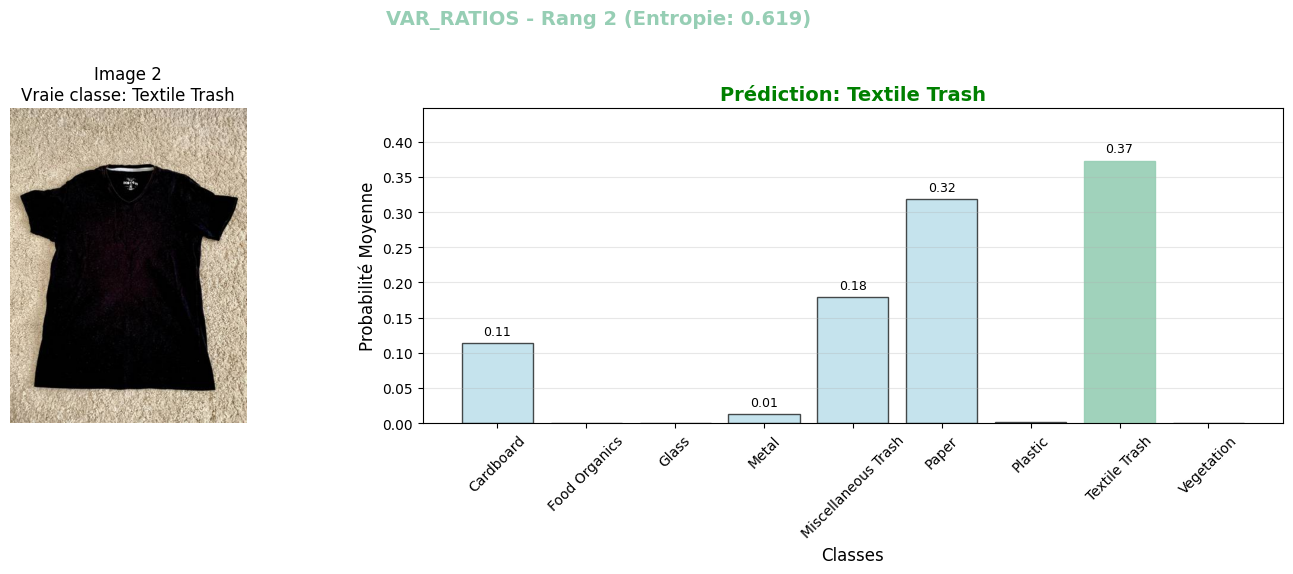

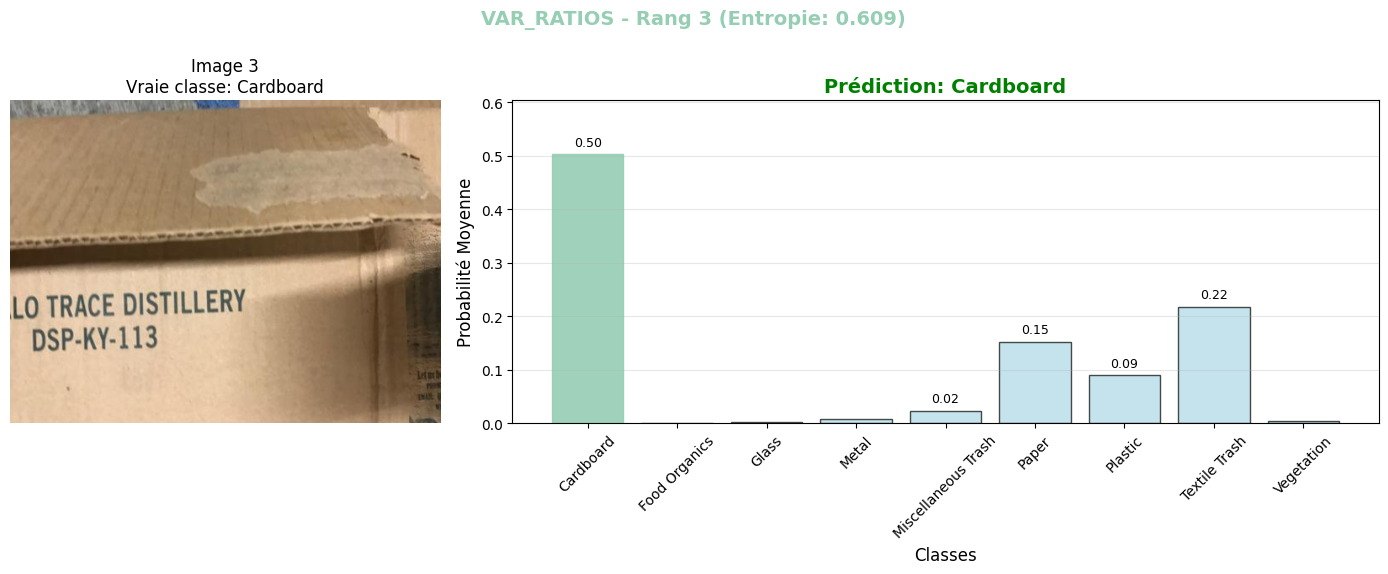


📉 Top 4 images avec le MOINS d'entropie (les plus sûres):


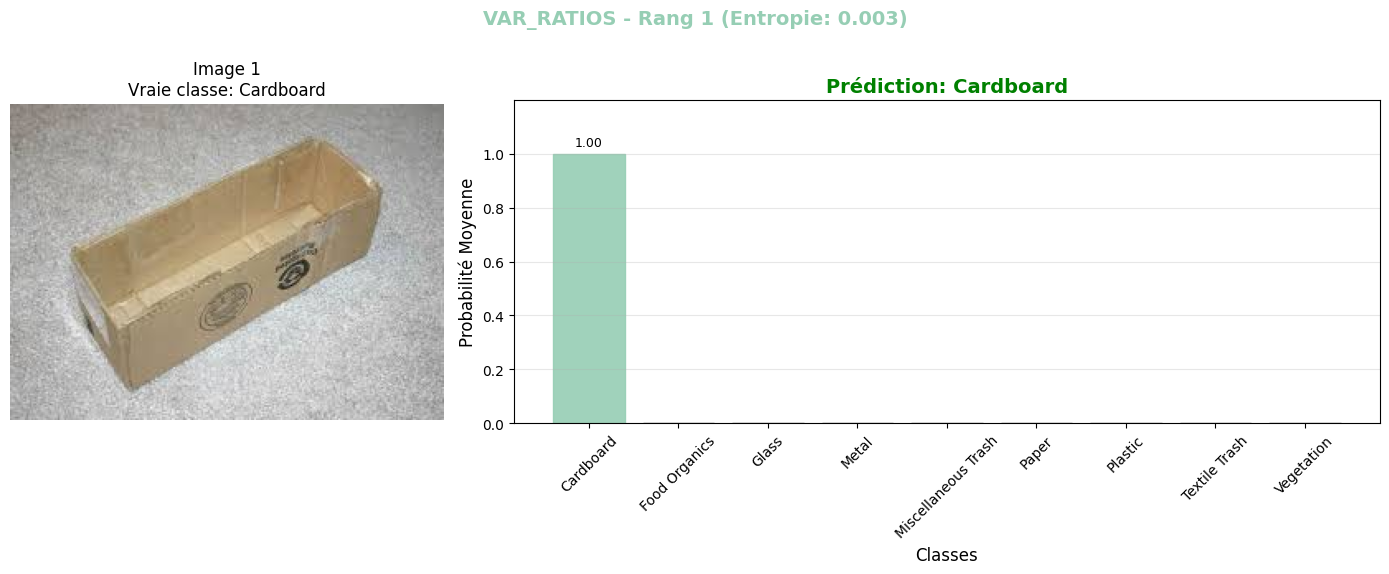

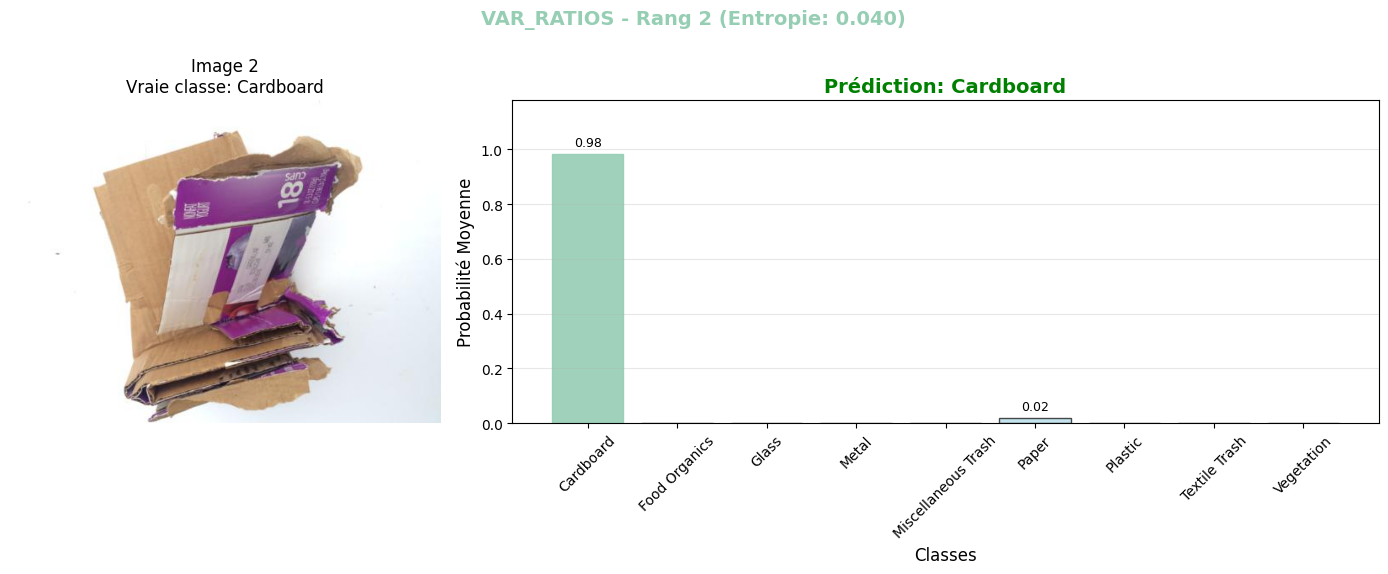

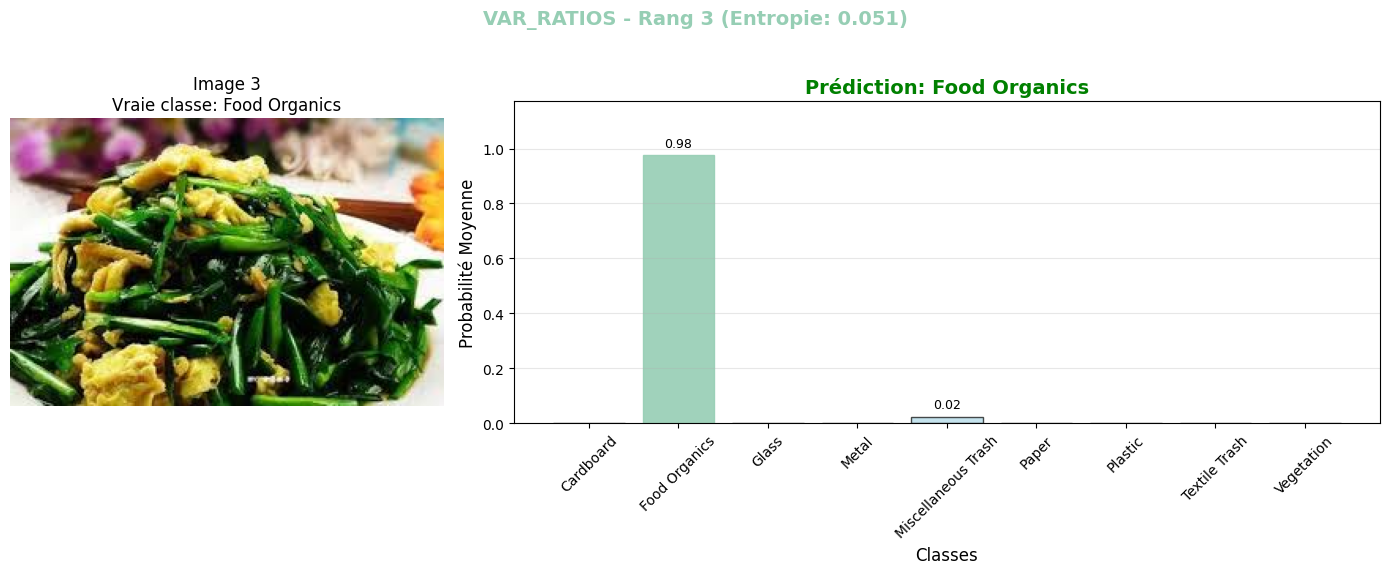


📈 Résumé VAR RATIOS (12 images):
   • Précision: 6/12 (50.0%)
   • Confiance moyenne: 0.746 (±0.234)
   • Entropie moyenne: 0.298 (±0.218)
✅ Analyse Var Ratios simplifiée terminée


In [14]:
# 🎲 Analyse VAR RATIOS - Version Simplifiée
if 'var_ratios' not in all_models:
    print("❌ Modèle Var Ratios non disponible")
else:
    strategy_name = 'var_ratios'
    model_var = all_models[strategy_name]
    color = '#96CEB4'
    
    print(f"🎲 Analyse simplifiée - Stratégie: {strategy_name.upper()}")
    
    # Analyser un ensemble d'images
    var_results = []
    for img_path, true_lbl in selected_images[:12]:
        result = analyze_strategy_simple(img_path, model_var, strategy_name)
        result['true_class'] = idx_to_class[true_lbl]
        var_results.append(result)
    
    # --- Visualisation des images avec le PLUS d'entropie ---
    var_results.sort(key=lambda x: x['entropy'], reverse=True)
    print(f"\n📊 Top {N_IMAGES_PER_STRATEGY} images avec le PLUS d'entropie:")
    for idx, result in enumerate(var_results[:N_IMAGES_PER_STRATEGY]):
        fig = plot_mc_prediction(result, strategy_name, color, idx + 1)
        plt.show()
        
    # --- Visualisation des images avec le MOINS d'entropie ---
    var_results.sort(key=lambda x: x['entropy'], reverse=False) # Tri ascendant
    print(f"\n📉 Top {N_IMAGES_PER_STRATEGY} images avec le MOINS d'entropie (les plus sûres):")
    for idx, result in enumerate(var_results[:N_IMAGES_PER_STRATEGY]):
        fig = plot_mc_prediction(result, strategy_name, color, idx + 1)
        plt.show()
    
    # Résumé statistique global
    confidences = [r['confidence'] for r in var_results]
    entropies = [r['entropy'] for r in var_results]
    correct_preds = sum(1 for r in var_results if r['pred_class'] == r['true_class'])
    
    print(f"\n📈 Résumé VAR RATIOS ({len(var_results)} images):")
    print(f"   • Précision: {correct_preds}/{len(var_results)} ({100*correct_preds/len(var_results):.1f}%)")
    print(f"   • Confiance moyenne: {np.mean(confidences):.3f} (±{np.std(confidences):.3f})")
    print(f"   • Entropie moyenne: {np.mean(entropies):.3f} (±{np.std(entropies):.3f})")
    print("✅ Analyse Var Ratios simplifiée terminée")

In [15]:
# 🏆 Comparaison Globale des Stratégies
print("🏆 COMPARAISON GLOBALE DES STRATÉGIES D'APPRENTISSAGE ACTIF")
print("=" * 60)

# Analyser les mêmes images avec toutes les stratégies disponibles
comparison_images = selected_images[:8]  # Prendre 8 images pour la comparaison
strategy_results = {}

for strategy_name, model in all_models.items():
    print(f"\n🔄 Analyse en cours: {strategy_name.upper()}")
    results = []
    
    for img_path, true_lbl in comparison_images:
        result = analyze_strategy_simple(img_path, model, strategy_name)
        result['true_class'] = idx_to_class[true_lbl]
        result['correct'] = result['pred_class'] == result['true_class']
        results.append(result)
    
    strategy_results[strategy_name] = results

# Créer un résumé comparatif
comparison_data = []
for strategy_name, results in strategy_results.items():
    accuracy = sum(1 for r in results if r['correct']) / len(results)
    avg_confidence = np.mean([r['confidence'] for r in results])
    avg_entropy = np.mean([r['entropy'] for r in results])
    
    comparison_data.append({
        'Stratégie': strategy_name.upper(),
        'Précision': f"{accuracy:.2%}",
        'Confiance Moy.': f"{avg_confidence:.3f}",
        'Entropie Moy.': f"{avg_entropy:.3f}"
    })

# Affichage du tableau comparatif
import pandas as pd
df_comparison = pd.DataFrame(comparison_data)
print(f"\n📊 RÉSUMÉ COMPARATIF ({len(comparison_images)} images testées):")
print(df_comparison.to_string(index=False))

# Graphique comparatif simple
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

strategies = [data['Stratégie'] for data in comparison_data]
confidences = [float(data['Confiance Moy.']) for data in comparison_data]
entropies = [float(data['Entropie Moy.']) for data in comparison_data]

# Graphique confiance
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'][:len(strategies)]
bars1 = ax1.bar(strategies, confidences, color=colors, alpha=0.7)
ax1.set_title('Confiance Moyenne par Stratégie', fontweight='bold')
ax1.set_ylabel('Confiance')
ax1.set_ylim(0, 1)
for bar, conf in zip(bars1, confidences):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{conf:.3f}', ha='center', fontweight='bold')

# Graphique entropie
bars2 = ax2.bar(strategies, entropies, color=colors, alpha=0.7)
ax2.set_title('Entropie Moyenne par Stratégie', fontweight='bold')
ax2.set_ylabel('Entropie')
for bar, ent in zip(bars2, entropies):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
             f'{ent:.3f}', ha='center', fontweight='bold')

plt.xticks(rotation=45)
plt.tight_layout()
plt.suptitle('🏆 Comparaison des Stratégies d\'Apprentissage Actif', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

print("\n✅ Analyse comparative terminée!")

🏆 COMPARAISON GLOBALE DES STRATÉGIES D'APPRENTISSAGE ACTIF

🔄 Analyse en cours: BALD

🔄 Analyse en cours: MAX_ENTROPY

🔄 Analyse en cours: MAX_ENTROPY

🔄 Analyse en cours: MEAN_STD_ACQUISITION

🔄 Analyse en cours: MEAN_STD_ACQUISITION

🔄 Analyse en cours: VAR_RATIOS

🔄 Analyse en cours: VAR_RATIOS

📊 RÉSUMÉ COMPARATIF (8 images testées):
           Stratégie Précision Confiance Moy. Entropie Moy.
                BALD    37.50%          0.771         0.270
         MAX_ENTROPY    50.00%          0.809         0.250
MEAN_STD_ACQUISITION    37.50%          0.788         0.230
          VAR_RATIOS    37.50%          0.830         0.190

📊 RÉSUMÉ COMPARATIF (8 images testées):
           Stratégie Précision Confiance Moy. Entropie Moy.
                BALD    37.50%          0.771         0.270
         MAX_ENTROPY    50.00%          0.809         0.250
MEAN_STD_ACQUISITION    37.50%          0.788         0.230
          VAR_RATIOS    37.50%          0.830         0.190


c:\Users\atcho\active_learning\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)



✅ Analyse comparative terminée!
